In [1]:
# load libraries

library(twitteR)
library(RMySQL)
library(ggmap)
library(maptools)
library(maps)
library(shiny)

Loading required package: DBI
Loading required package: ggplot2
Loading required package: sp
Checking rgeos availability: FALSE
 	Note: when rgeos is not available, polygon geometry 	computations in maptools depend on gpclib,
 	which has a restricted licence. It is disabled by default;
 	to enable gpclib, type gpclibPermit()


In [2]:
# authenticate twitter api

setup_twitter_oauth("IqXBbuoo7e4KPTz5zaselsOxX", "mzqdTv2pEmlWAhw3t05caF8TBwhHIKUkxHAyvXEkX4tAx0CYte", 
                    "528707786-TWf9LWsGnveVFdmZEsEVC1QKO6fLNluBdXgUlmvU", "PUt70tjC71FLujjFyui2wWOY2rYT0tZgh2djRh2GUalnJ")

[1] "Using direct authentication"


In [3]:
# register db for storing

register_mysql_backend(db_name = "DIC", host = "localhost", user = "root", password = "root")

In [4]:
# connect to db

mydb = dbConnect(MySQL(), user='root', password='root', dbname='DIC', host='localhost')

In [6]:
# connect to twitter and fetch tweets till 20000 are found
# store these tweets in the database

search_twitter_and_store(searchString = "SuperBowl", table_name = "Tweets")
repeat{
    count = fetch(dbSendQuery(mydb, "SELECT count(*) from Tweets"))[[1]][1]
    if(count > 20000) break
    search_twitter_and_store(searchString = "SuperBowl", table_name = "Tweets")
}

In [7]:
# list tables

dbListTables(mydb)

[1] "Test"   "Tweets" "Users"

In [8]:
# fetch all unique users from the tweets fetched and stored in DB
users = fetch(dbSendQuery(mydb, "SELECT distinct(screenName) from Tweets"),n=-1)

In [9]:
# create blank dataframe to store user locations

userDF = data.frame(
                    "screenName" = character(),
                    "latitude" = integer(),
                    "longitude" = integer(),
                    "row_number" = integer(),
#                     "location" = character(),
                    stringsAsFactors = FALSE)

In [10]:
userDF = fetch(dbSendQuery(mydb,'SELECT * from Users'),n=-1)

In [11]:
# loop through all users to get their location using Google Geocode API
# store the username along with longitude and latitude in the dataframe

startFrom = 0
count = startFrom
repeat{
    count = count + 1
    
    # sleep after every 900 users [ twitter limit ]
    if((count - startFrom) %% 900 == 0) Sys.sleep(960)
        
    # if all processed then break
    if(count > length(users$screenName)) break
        
    # fetch user info from twitter api    
    userInfo <- try(getUser(users$screenName[count]))
        
    # if API error (user deleted/blocked) then move on to next user    
    if (class(userInfo) == "try-error") next
        
    # get coordinates from google geocode API    
    coords <- try(suppressWarnings(suppressMessages((as.numeric(geocode(userInfo$location))))))#, source="dsk")))
    
    # if no coordinates found then move no to next user
    if (class(coords) == "try-error") next
        
    # if any coordinates is NA then move on to next user
    if (is.na(coords[[1]]) || is.na(coords[[2]])) next
        
    # insert this data in the user dataframe
    userDF = rbind(userDF, data.frame(screenName=users$screenName[count], 
                                      latitude=as.integer(coords[[2]]),
                                      longitude=as.integer(coords[[1]]), 
                                      row_names=(as.integer(userDF$row_names[nrow(userDF)])+1),
                                      stringsAsFactors = FALSE))
}

In [12]:
# write the user data to database from future use

dbWriteTable(mydb,name = "Users",value = userDF, overwrite=TRUE, row.names=FALSE)

[1] TRUE

In [13]:
# get users from DB

userDF = fetch(dbSendQuery(mydb, "SELECT * from Users"),n=-1)

In [14]:
# preview user dataframe

tail(userDF)
nrow(userDF)

,row_names,screenName,latitude,longitude
2698,2698,ChapmanMediaNet,43,-79
2699,2699,leolenderly,-24,-46
2700,2700,2coldcoronas,32,-117
2701,2701,3a3f4d9e87a242a,31,-99
2702,2702,karmacom,40,-73
2703,2703,footballcafe,34,-118


[1] 2703

In [15]:
# get grouped lat longs to be plotted on map

groupedCoords = dbGetQuery(mydb,"select count(*) as count,longitude,latitude from Users group by longitude,latitude order by count desc")
head(groupedCoords)

count,longitude,latitude
136,-71,42
120,-74,40
79,-95,37
76,-118,34
66,0,51
45,-95,29


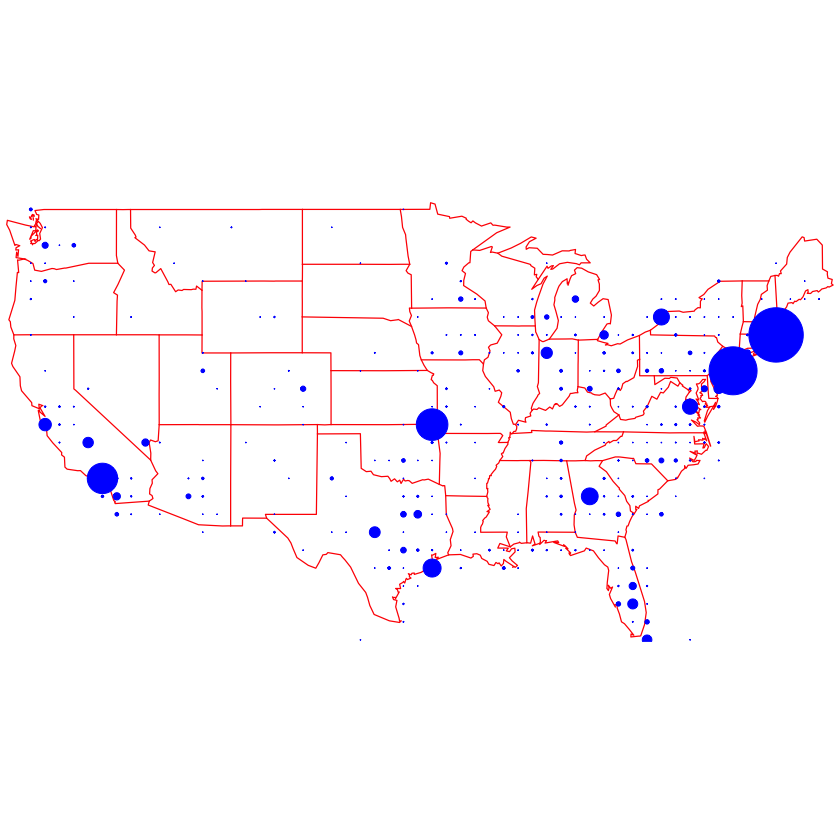

In [16]:
# plot the locations on map of US

map("state", fill=FALSE, col="red", bg="white", mar=c(0,0,0,0))
points(groupedCoords$longitude, groupedCoords$latitude, pch=20, cex=groupedCoords$count/15, lwd=.8, col="blue")

